<a href="https://colab.research.google.com/github/theoadepaula/BrasiliaWorkshop/blob/master/TCC_Modelagem_Compilado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Esse notebook apresenta a modelagem para o 1º cenário, a partir do dataframe original de dados***

# **Pré-Processamento dos Dados**

### Instalação das Bibliotecas Sktime e Scikeras

In [ ]:
pip install sktime[all_extras]

     |████████████████████████████████| 6.6 MB 4.8 MB/s 
     |████████████████████████████████| 9.8 MB 45.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.7 MB/s 
     |████████████████████████████████| 116 kB 64.1 MB/s 
     |████████████████████████████████| 6.9 MB 32.9 MB/s 
     |████████████████████████████████| 580 kB 71.9 MB/s 
     |████████████████████████████████| 11.2 MB 35.7 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.4 MB 37.2 MB/s 
     |████████████████████████████████| 65 kB 4.6 MB/s 
     |████████████████████████████████| 136 kB 50.5 MB/s 
     |████████████████████████████████| 793 kB 57.9 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 788 kB 38.7 MB/s 
     |██████

### Instalação das Bibliotecas Matplotlib, Numpy e Pandas

In [1]:
from sktime.utils.plotting import plot_series
import matplotlib
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: ignored

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importação da base de dados mensal

In [ ]:
#Importação das séries de vazão e precipitação
df = pd.read_csv('df.csv', parse_dates=['Data'], index_col='Data')
df.index=df.index.to_period("M")
df.head()

## Transformação das Curvas

In [ ]:
#Funções para reverter as transformações
def power_2(x):
  return(np.power(x,2))

def base_10(x):
  return(np.power(10,x))


In [ ]:
#Transformações: log(vazão) e raiz(precipitação)
from sklearn.preprocessing import FunctionTransformer

transformer_log = FunctionTransformer(np.log10, inverse_func = base_10 , validate = True,check_inverse=False)
transformer_sqrt = FunctionTransformer(np.sqrt, inverse_func= power_2, validate = True,check_inverse=False)

df[['Vazao']] = transformer_log.fit_transform(df[['Vazao']])
df[['Precipitacao']] = transformer_sqrt.fit_transform(df[['Precipitacao']])
df.head()

## Normalização dos Dados

In [ ]:
#Colocando na escala de 0.1 a 0.9
from sklearn.preprocessing import MinMaxScaler

scaler_1 = MinMaxScaler(feature_range=(0.1,0.9))
scaler_2 = MinMaxScaler(feature_range=(0.1,0.9))

df[['Vazao']] = scaler_1.fit_transform(df[['Vazao']])
df[['Precipitacao']] = scaler_2.fit_transform(df[['Precipitacao']])
df.head()

,Vazao,Precipitacao
Data,,
1941-01,0.635201,0.553585
1941-02,0.574807,0.455188
1941-03,0.598114,0.451790
1941-04,0.571008,0.351784
1941-05,0.470447,0.241956


**Divisão da Base de Dados**

In [ ]:
#Divisão da base em treino e teste
y=df['Vazao']
X=df.drop('Vazao',axis=1)

from sktime.forecasting.model_selection import temporal_train_test_split

y_train,y_test,x_train,x_test= temporal_train_test_split(y,X,test_size=0.25)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

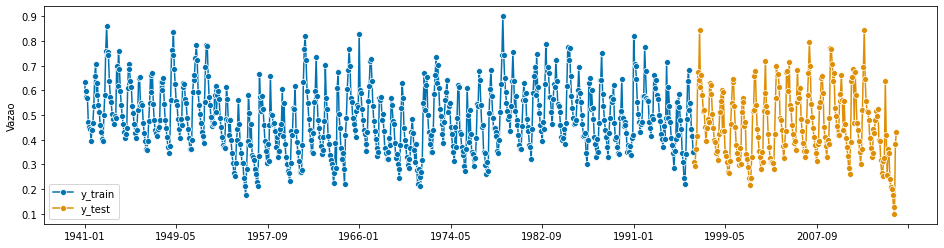

In [ ]:
plot_series(y_train,y_test, labels=["y_train", "y_test"])

**Definição dos Horizontes de plotagem e previsão**

In [ ]:
#Definição do período de plotagem dos dados
y_train_menor=y_train[600:]

#Definição do horizonte de previsão
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

# **Aplicação dos Modelos estatísticos**



```
# Isto está formatado como código
```

## Modelo Naive (referência)

In [ ]:
#Ajuste do Naive
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

forecaster_naive = NaiveForecaster(strategy="last", sp=12)
forecaster_naive.fit(y_train)

NaiveForecaster(sp=12)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

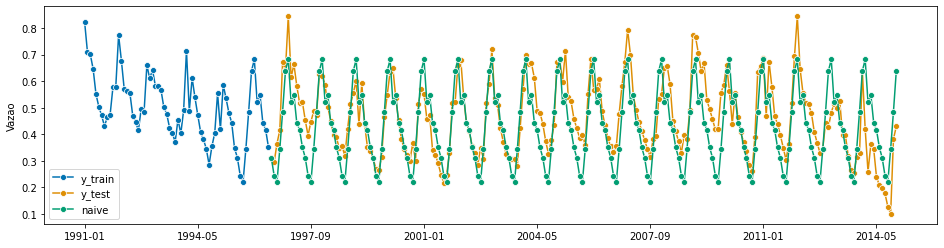

In [ ]:
#Previsões do Naive
y_pred_naive = forecaster_naive.predict(fh)

plot_series(y_train_menor, y_test, y_pred_naive, labels=["y_train", "y_test", "naive"])

## Modelo AutoARIMA (referência)

In [ ]:
#Ajuste do AutoARIMA
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima = AutoARIMA(start_p=1, d=None, start_q=1, max_p=4, max_d=1, max_q=4, start_P=1, 
                                 D=None, start_Q=1, max_P=4, max_D=1, max_Q=4, sp=12, seasonal=True, stationary=True, information_criterion='aic', alpha=0.05, test='kpss', 
                                 seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='nm', maxiter=50, offset_test_args=None, 
                                 seasonal_test_args=None, suppress_warnings=True, error_action='warn', trace=False, random=False, random_state=None, n_fits=10, 
                                 out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept=True)
forecaster_autoarima.fit(y_train)

print(forecaster_autoarima.summary())

                                           SARIMAX Results                                           
Dep. Variable:                                             y   No. Observations:                  666
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2, 3, 4], 12)   Log Likelihood                 811.720
Date:                                       Tue, 12 Apr 2022   AIC                          -1609.440
Time:                                               20:38:06   BIC                          -1577.931
Sample:                                                    0   HQIC                         -1597.232
                                                       - 666                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1340     

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

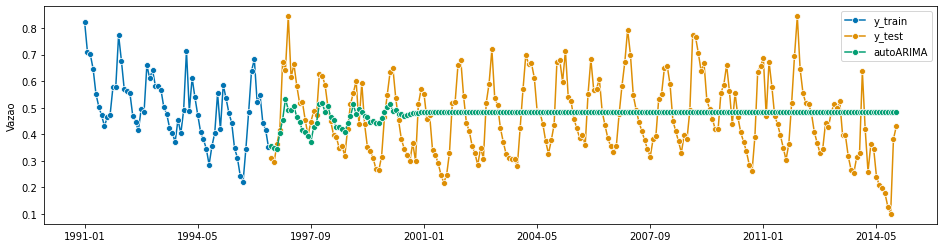

In [ ]:
#Previsões do AutoARIMA
y_pred_autoarima = forecaster_autoarima.predict(fh)

plot_series(y_train_menor, y_test, y_pred_autoarima, labels=["y_train", "y_test", "autoARIMA"])

## Modelo AutoARIMA exógeno

In [ ]:
#Ajuste do AutoARIMA exógeno
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima_exo = AutoARIMA(start_p=1, d=None, start_q=1, max_p=4, max_d=1, max_q=4, start_P=1, D=None, start_Q=1, max_P=4, max_D=1, max_Q=4, sp=12, seasonal=True, stationary=True, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=20, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='warn', random=False, random_state=None, n_fits=10, out_of_sample_size=0, scoring='mse', scoring_args=None)
forecaster_autoarima_exo.fit(y_train,X=x_train)

print(forecaster_autoarima_exo.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  666
Model:             SARIMAX(2, 0, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood                1061.753
Date:                                    Wed, 13 Apr 2022   AIC                          -2099.506
Time:                                            12:11:25   BIC                          -2045.491
Sample:                                        01-31-1941   HQIC                         -2078.578
                                             - 06-30-1996                                         
Covariance Type:                                      opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0076      0.010      0.730 

In [ ]:
#Ajuste do AutoARIMA exógeno - graus 1 ou 2
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima_exo_g2 = AutoARIMA(start_p=1, min_d=None, start_q=1, max_p=2, max_d=1, max_q=2, start_P=1, min_D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, sp=12, seasonal=True, stationary=True, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=100, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='warn', random=False, random_state=None, n_fits=10, out_of_sample_size=0, scoring='mse', scoring_args=None)
forecaster_autoarima_exo_g2.fit(y_train,X=x_train)

print(forecaster_autoarima_exo_g2.summary())

In [ ]:
#Comparação das previsões dos AutoARIMA exógenos

y_pred_autoarima_exo = forecaster_autoarima_exo.predict(fh,X=x_test)
y_pred_autoarima_exo_g2 = forecaster_autoarima_exo_g2.predict(fh,X=x_test)

plot_series(y_train_menor, y_pred_autoarima_exo, y_pred_autoarima_exo_g2, labels=["y_train", "autoARIMA exo", "autoARIMA exo g2"])

## Modelo SARIMAx

In [ ]:
#Ajuste do Sarimax
from sktime.forecasting.arima import ARIMA
forecaster_arima_exo = ARIMA(
    order=(1,0,1), seasonal_order=(1,0,1, 12),
    maxiter=100,
    suppress_warnings=True,
    time_varying_regression=True
)

forecaster_arima_exo.fit(y_train,X=x_train)
print(forecaster_arima_exo.summary())


In [ ]:
#Previsões do Sarimax
y_pred_arima_exo = forecaster_arima_exo.predict(fh,X=x_test)
plot_series(y_train_menor, y_test, y_pred_arima_exo, 
            labels=["y_train", "y_test", "ARIMA exo"])

## Modelo Prophet

In [ ]:
#Ajuste do Prophet
from sktime.forecasting.fbprophet import Prophet

z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=222)
ds=df['Precipitacao']
ds = ds.to_timestamp(freq="M")
ds_train, ds_test = temporal_train_test_split(ds, test_size=222)

forecaster_prophet = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(y_train) / 12),
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster_prophet.fit(z_train,X=ds_train)



(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

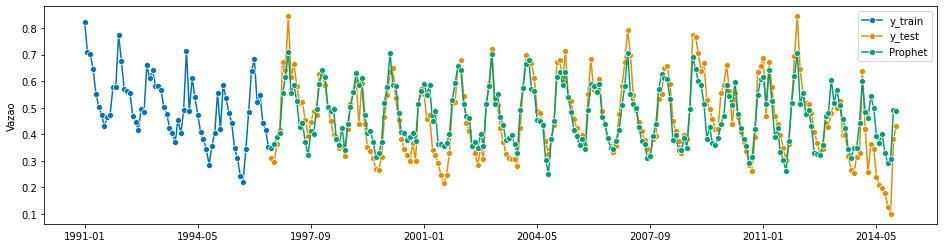

In [ ]:
#Previsões do Prophet
y_pred_prophet= forecaster_prophet.predict(fh.to_relative(cutoff=y_train.index[-1]),ds_test )
y_pred_prophet.index = y_test.index

plot_series(y_train_menor, y_test, y_pred_prophet, labels=["y_train", "y_test", "Prophet"])

## Comparação entre os modelos

In [ ]:
print('MAPE')
print('Naive :        ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :    ',mean_absolute_percentage_error(y_test, y_pred_autoarima,symmetric=False).round(5))
print('AutoARIMA exo :',mean_absolute_percentage_error(y_test, y_pred_autoarima_exo_g2,symmetric=False).round(5))
print('SARIMAx :      ',mean_absolute_percentage_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_absolute_percentage_error(y_test, y_pred_prophet,symmetric=False).round(5))
print('MSE')
print('Naive :       ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :   ',mean_squared_error(y_test, y_pred_autoarima).round(5))
print('AutoARIMA exo :',mean_squared_error(y_test, y_pred_autoarima_exo_g2).round(5))
print('SARIMAx :      ',mean_squared_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_squared_error(y_test, y_pred_prophet).round(5))

MAPE
Naive :         0.19152
AutoARIMA :     0.30481
AutoARIMA exo : 0.17862
SARIMAx :       0.16482
Prophet :       0.14683
MSE
Naive :        0.19152
AutoARIMA :    0.01907
AutoARIMA exo : 0.00658
SARIMAx :       0.00587
Prophet :       0.0049


In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_autoarima,
            y_pred_autoarima_exo,
            y_pred_arima_exo,
            y_pred_prophet,
            labels=["y_train", "y_test", 
                    'AutoARIMA',
                    'AutoARIMA exo',
                    'ARIMA exo',
                    'Prophet'])

## Cross Validation dos modelos

In [100]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError


cv = SlidingWindowSplitter(
    fh=60, window_length=300, step_length = 36
)


In [115]:
df_naive = evaluate(forecaster=forecaster_naive, y=y, cv=cv, strategy="refit", return_data=True)

df_naive_mse = evaluate(forecaster=forecaster_naive, y=y, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [ ]:
df_autoarima = evaluate(forecaster=forecaster_autoarima, y=y, cv=cv, strategy="refit", return_data=True)

df_autoarima_mse = evaluate(forecaster=forecaster_autoarima, y=y, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [ ]:
df_autoarima_exo = evaluate(forecaster=forecaster_autoarima_exo_g2, y=y, X=X, cv=cv, strategy="refit", return_data=True)

df_autoarima_exo_mse = evaluate(forecaster=forecaster_autoarima_exo_g2, y=y, X=X, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [ ]:
df_arima_exo = evaluate(forecaster=forecaster_arima_exo, y=y, X=X, cv=cv, strategy="refit", return_data=True)

df_arima_exo_mse = evaluate(forecaster=forecaster_arima_exo, y=y, X=X, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [ ]:
dsnovo=df.drop('Vazao',axis=1)
dsnovo=dsnovo.to_timestamp(freq='M')

In [ ]:
df_prophet = evaluate(forecaster=forecaster_prophet, y=z,X=dsnovo, cv=cv, strategy="refit", return_data=True)

df_prophet_mse = evaluate(forecaster=forecaster_prophet, y=z,X=dsnovo, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

### Comparação entre os modelos

In [ ]:
print('Média sMAPE dos modelos da Validação Cruzada:')
print('Naive :         ',round(df_naive['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA :     ',round(df_autoarima['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA exo : ',round(df_autoarima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('SARIMAx :       ',round(df_arima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('Prophet :       ',round(df_prophet['test_MeanAbsolutePercentageError'].mean(),5))
print('Média MSE dos modelos da Validação Cruzada:')
print('Naive :        ',round(df_naive_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA :    ',round(df_autoarima_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA exo :',round(df_autoarima_exo_mse['test_MeanSquaredError'].mean(),5))
print('SARIMAx :      ',round(df_arima_exo_mse['test_MeanSquaredError'].mean(),5))
print('Prophet :      ',round(df_prophet_mse['test_MeanSquaredError'].mean(),5))

Média sMAPE dos modelos da Validação Cruzada:
Naive :          0.1177
AutoARIMA :      0.23532
AutoARIMA exo :  0.07665
SARIMAx :        0.08131
Prophet :        0.13506
Média MSE dos modelos da Validação Cruzada:
Naive :         0.00721
AutoARIMA :     0.02109
AutoARIMA exo : 0.0028
SARIMAx :       0.00299
Prophet :       0.00953


# **Construção e Aplicação das Redes Neurais**

##Pré-Processamento

In [ ]:
#Importação de bibliotecas
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed
from keras.layers import Dropout


## Rede MLP

In [ ]:
#Construção da rede neural
modelDense = keras.models.Sequential()
modelDense.add(keras.layers.Dense(16, activation='tanh', input_dim=1))
modelDense.add(keras.layers.Dense(4, activation='tanh'))
modelDense.add(Dropout(0.2))
modelDense.add(keras.layers.Dense(1, activation='linear'))
modelDense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Definição de estado
seed(2)
set_seed(2)

#Definição de parâmetros de ajuste
batch_size = 64
epochs = 100
learning_rate = 0.01

#Ajuste da rede
modelDense.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
hist_dense = modelDense.fit(x=x_train,y=y_train, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

MAPE dos modelos
Dense:                               0.17619
MSE dos modelos:
Dense:                               0.00907


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

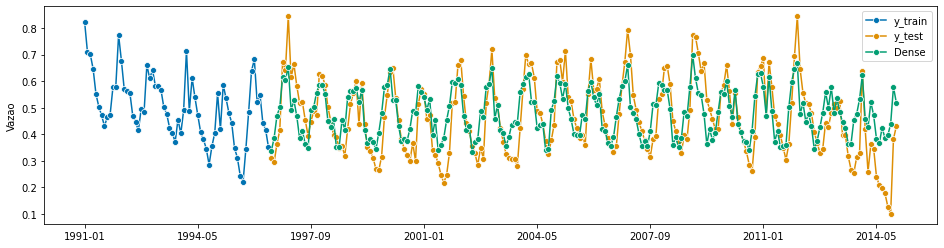

In [ ]:
#Previsão e métricas da rede
pred_dense = modelDense.predict(x_test).reshape(-1)
mse_dense = mean_squared_error(y_test, pred_dense)
mape_dense = mean_absolute_percentage_error(y_test, pred_dense)

print('MAPE dos modelos')
print('Dense:                              ',mape_dense.round(5))

print('MSE dos modelos:')
print('Dense:                              ',mse_dense.round(5))

y_pred_dense=pd.Series(pred_dense, index=y_test.index)
plot_series(y_train_menor, y_test,
            y_pred_dense,
            labels=["y_train", "y_test", 
                    'Dense'])

## Rede Recorrente

In [ ]:
#Criação da função time_step
def create_dataset_time_step(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
#Definição do time step e bases de treino e teste
time_steps = 3

X_train_ts, y_train_ts = create_dataset_time_step(x_train,y_train, time_steps)
X_test_ts, y_test_ts = create_dataset_time_step(x_test,y_test, time_steps)

print(X_train_ts.shape, y_train_ts.shape)

(663, 3, 1) (663,)


In [ ]:
#Construção da rede neural recorrente
modelSimpleRNN = keras.models.Sequential()
modelSimpleRNN.add(keras.layers.SimpleRNN(16, activation='tanh', return_sequences=True, input_shape=(X_train_ts.shape[1],X_train_ts.shape[2])))
modelSimpleRNN.add(keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(keras.layers.Dense(1, activation='linear'))
modelSimpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 16)             288       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 84        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 377
Trainable params: 377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Definição de estado
seed(2)
set_seed(2)

#Definição de parâmetros de ajuste
batch_size = 64
epochs = 100
learning_rate = 0.01

#Ajuste da RNR
modelSimpleRNN.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate,decay=0.001),metrics=['mse'])
hist_SimpleRNN = modelSimpleRNN.fit(x=X_train_ts, y=y_train_ts, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

In [ ]:
#Previsão e métricas da rede
pred_SimpleRNN = modelSimpleRNN.predict(X_test_ts)
mse_SimpleRNN = mean_squared_error(y_test_ts, pred_SimpleRNN)
mape_SimpleRNN = mean_absolute_percentage_error(y_test_ts, pred_SimpleRNN)

print('MAPE dos modelos')
print('RNN:                               ',mape_SimpleRNN.round(5))

print('MSE dos modelos:')
print('RNN:                               ',mse_SimpleRNN.round(5))

MAPE dos modelos
RNN:                                0.14989
MSE dos modelos:
RNN:                                0.00739


# Comparação dos modelos sem validação cruzada

In [ ]:
print('MAPE')
print('Naive :        ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :    ',mean_absolute_percentage_error(y_test, y_pred_autoarima,symmetric=False).round(5))
print('AutoARIMA exo :',mean_absolute_percentage_error(y_test, y_pred_autoarima_exo_g2,symmetric=False).round(5))
print('SARIMAx :      ',mean_absolute_percentage_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_absolute_percentage_error(y_test, y_pred_prophet,symmetric=False).round(5))
print('Dense :        ',mape_dense.round(5))
print('RNN :          ',mape_SimpleRNN.round(5))
print('MSE')
print('Naive :       ',mean_absolute_percentage_error(y_test, y_pred_naive,symmetric=False).round(5))
print('AutoARIMA :   ',mean_squared_error(y_test, y_pred_autoarima).round(5))
print('AutoARIMA exo :',mean_squared_error(y_test, y_pred_autoarima_exo_g2).round(5))
print('SARIMAx :      ',mean_squared_error(y_test, y_pred_arima_exo,symmetric=False).round(5))
print('Prophet :      ',mean_squared_error(y_test, y_pred_prophet).round(5))
print('Dense :        ',mse_dense.round(5))
print('RNN :          ',mse_SimpleRNN.round(5))

MAPE
Naive :         0.19152
AutoARIMA :     0.30481
AutoARIMA exo : 0.17862
SARIMAx :       0.16482
Prophet :       0.14683
Dense :         0.17619
RNN :           0.14989
MSE
Naive :        0.19152
AutoARIMA :    0.01907
AutoARIMA exo : 0.00658
SARIMAx :       0.00587
Prophet :       0.0049
Dense :         0.00907
RNN :           0.00739


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

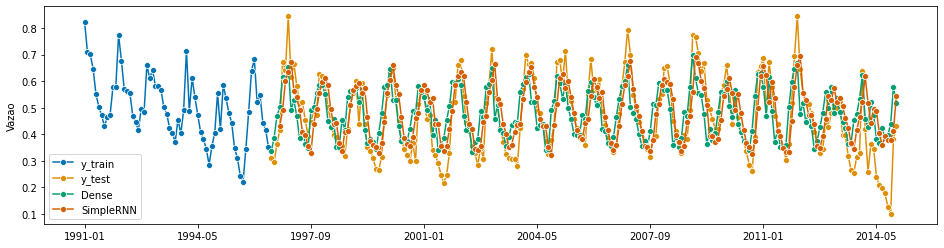

In [ ]:
y_pred_SimpleRNN=pd.Series(pred_SimpleRNN.reshape(-1), index=y_test.index[time_steps::])
plot_series(y_train_menor, y_test,
            y_pred_dense,
            y_pred_SimpleRNN,
            labels=["y_train", "y_test", 
                    'Dense',
                    'SimpleRNN'
                    ])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

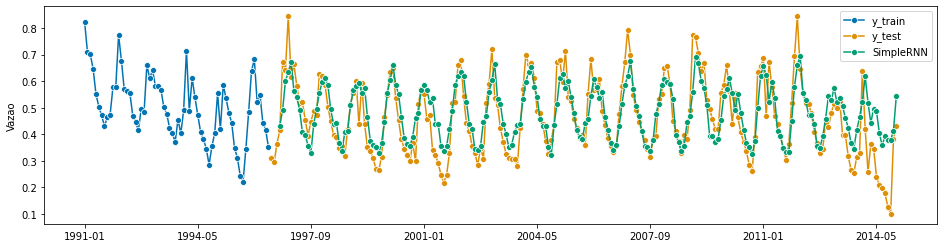

In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_SimpleRNN,
            labels=["y_train", "y_test", 
                    'SimpleRNN'
                    ])

Gráfico dos melhores modelos

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

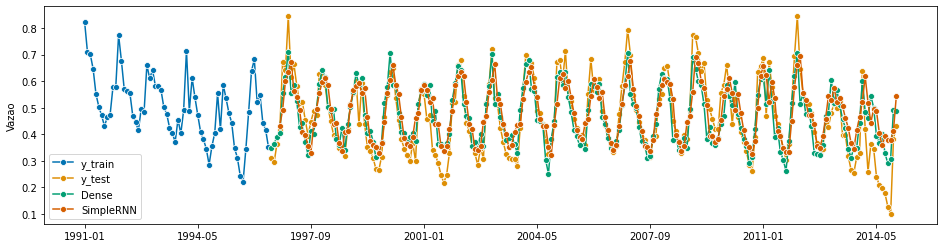

In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_prophet,
            y_pred_SimpleRNN,
            labels=["y_train", "y_test", 
                    'Dense',
                    'SimpleRNN'
                    ])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

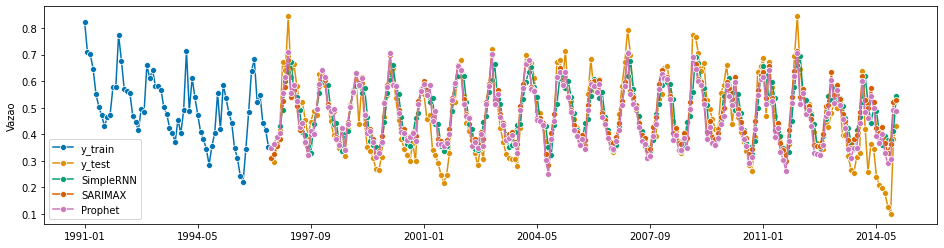

In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_SimpleRNN,
            y_pred_arima_exo,
            y_pred_prophet,
            labels=["y_train", "y_test", 
                    'SimpleRNN',
                    'SARIMAX',
                    'Prophet'])

### CENÁRIO 2

# **Cross Validation**

In [79]:
X_cv = df['Precipitacao']
y_cv = df['Vazao']

dense_cv_y = []
dense_cv_pred = []

fold = 0
for train, test in cv.split(y):
    fold+=1
    gp_test = np.arange(test-59,test+1)
    print(f"Fold #{fold}")

    x_train_cv = X_cv[train]
    y_train_cv = y_cv[train]
    x_test_cv = X_cv[gp_test]
    y_test_cv = y_cv[gp_test]

    modelDense_cv = keras.models.Sequential()
    modelDense_cv.add(keras.layers.Dense(16, activation='tanh', input_dim=1))
    modelDense_cv.add(keras.layers.Dense(4, activation='tanh'))
    modelDense_cv.add(Dropout(0.2))
    modelDense_cv.add(keras.layers.Dense(1, activation='linear'))
    modelDense_cv.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
    
    modelDense_cv.fit(x_train_cv,y_train_cv,validation_data=(x_test_cv,y_test_cv),verbose=0,
              epochs=epochs)
    
    pred_dense_cv = modelDense_cv.predict(x_test_cv)
    
    dense_cv_y.append(y_test_cv)
    dense_cv_pred.append(pred_dense_cv)  
        
    mse_dense_fold = mean_squared_error(pred_dense_cv,y_test_cv)
    mape_dense_fold = mean_absolute_percentage_error(pred_dense_cv,y_test_cv)
    print(f"Fold dense (MAPE): {mape_dense_fold}")
    print(f"Fold dense (MSE): {mse_dense_fold}") 

Fold #1
Fold dense (MAPE): 0.173433455876547
Fold dense (MSE): 0.008106917651040723
Fold #2
Fold dense (MAPE): 0.20338464073874765
Fold dense (MSE): 0.009909641422678174
Fold #3
Fold dense (MAPE): 0.13345231710599517
Fold dense (MSE): 0.005567067331348493
Fold #4
Fold dense (MAPE): 0.15130029429641
Fold dense (MSE): 0.00918351672590596
Fold #5
Fold dense (MAPE): 0.1813521895898065
Fold dense (MSE): 0.012560077361909894
Fold #6
Fold dense (MAPE): 0.16894565368019013
Fold dense (MSE): 0.01023266737967524
Fold #7
Fold dense (MAPE): 0.1462959713570385
Fold dense (MSE): 0.007420035627202116
Fold #8
Fold dense (MAPE): 0.14028325769946495
Fold dense (MSE): 0.0067128460594933536
Fold #9
Fold dense (MAPE): 0.14064520163853342
Fold dense (MSE): 0.006722668241236042
Fold #10
Fold dense (MAPE): 0.14652022552174468
Fold dense (MSE): 0.007036197372220557
Fold #11
Fold dense (MAPE): 0.15247284316710497
Fold dense (MSE): 0.007551806350064997
Fold #12
Fold dense (MAPE): 0.18948165278621956
Fold dense (

testando um arima de ordem menor

In [116]:
X_cv = df['Precipitacao']
y_cv = df['Vazao']

SimpleRNN_cv_y = []
SimpleRNN_cv_pred = []
time_steps=3

fold = 0
for train, test in cv.split(y):
    fold+=1
    gp_test = np.arange(test-59,test+1)
    print(f"Fold #{fold}")

    x_train_cv = X_cv[train]
    y_train_cv = y_cv[train]
    x_test_cv = X_cv[gp_test]
    y_test_cv = y_cv[gp_test]    

    X_train_ts_cv, y_train_ts_cv = create_dataset_time_step(x_train_cv,y_train_cv, time_steps)
    X_test_ts_cv, y_test_ts_cv = create_dataset_time_step(x_test_cv,y_test_cv, time_steps)

    X_train_ts_cv=X_train_ts_cv.reshape(300-time_steps,time_steps,1)
    X_test_ts_cv=X_test_ts_cv.reshape(60-time_steps,time_steps,1)

    modelSimpleRNN_cv = keras.models.Sequential()
    modelSimpleRNN_cv.add(keras.layers.SimpleRNN(16, activation='tanh', return_sequences=True, input_shape=(X_train_ts.shape[1],X_train_ts.shape[2])))
    modelSimpleRNN_cv.add(keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False))
    modelSimpleRNN_cv.add(Dropout(0.2))
    modelSimpleRNN_cv.add(keras.layers.Dense(1, activation='linear'))
    modelSimpleRNN_cv.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
    modelSimpleRNN_cv.fit(x=X_train_ts_cv, y=y_train_ts_cv, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

    pred_SimpleRNN_cv = modelSimpleRNN_cv.predict(X_test_ts_cv)

    SimpleRNN_cv_y.append(y_test_ts_cv)
    SimpleRNN_cv_pred.append(pred_SimpleRNN_cv) 

    mse_SimpleRNN_fold = mean_squared_error(pred_SimpleRNN_cv,y_test_ts_cv)
    mape_SimpleRNN_fold = mean_absolute_percentage_error(pred_SimpleRNN_cv,y_test_ts_cv)
    print(f"Fold SimpleRNN (MAPE): {mape_SimpleRNN_fold}") 
    print(f"Fold SimpleRNN (MSE): {mse_SimpleRNN_fold}") 


Fold #1
Fold SimpleRNN (MAPE): 0.14004669350716203
Fold SimpleRNN (MSE): 0.005322571776832704
Fold #2
Fold SimpleRNN (MAPE): 0.20334520788790697
Fold SimpleRNN (MSE): 0.009636063371584801
Fold #3
Fold SimpleRNN (MAPE): 0.1372332944129225
Fold SimpleRNN (MSE): 0.0058388706593662625
Fold #4
Fold SimpleRNN (MAPE): 0.15806597463613337
Fold SimpleRNN (MSE): 0.008018451884753815
Fold #5
Fold SimpleRNN (MAPE): 0.14967287901044096
Fold SimpleRNN (MSE): 0.008990875804405465
Fold #6
Fold SimpleRNN (MAPE): 0.14653150681831298
Fold SimpleRNN (MSE): 0.008098664406188208
Fold #7
Fold SimpleRNN (MAPE): 0.11262579370549189
Fold SimpleRNN (MSE): 0.004627603417217347
Fold #8
Fold SimpleRNN (MAPE): 0.11977633884934212
Fold SimpleRNN (MSE): 0.0055564082525798334
Fold #9
Fold SimpleRNN (MAPE): 0.12277328985057838
Fold SimpleRNN (MSE): 0.00657923163643657
Fold #10
Fold SimpleRNN (MAPE): 0.13424987305044694
Fold SimpleRNN (MSE): 0.006165876270974085
Fold #11
Fold SimpleRNN (MAPE): 0.13703120237907473
Fold Si

In [117]:
dense_cv_y_1 = np.concatenate(dense_cv_y)
dense_cv_pred_1 = np.concatenate(dense_cv_pred)

SimpleRNN_cv_y_1 = np.concatenate(SimpleRNN_cv_y)
SimpleRNN_cv_pred_1 = np.concatenate(SimpleRNN_cv_pred)


In [118]:
mape_dense_cv = mean_absolute_percentage_error(dense_cv_pred_1,dense_cv_y_1)
mse_dense_cv = mean_squared_error(dense_cv_pred_1,dense_cv_y_1)
print(f" MAPE - Validação Cruzada - Dense : {mape_dense_cv}") 
print(f" MSE - Validação Cruzada - Dense : {mse_dense_cv}") 
print("") 
mape_SimpleRNN_cv = mean_absolute_percentage_error(SimpleRNN_cv_pred_1,SimpleRNN_cv_y_1)
mse_SimpleRNN_cv = mean_squared_error(SimpleRNN_cv_pred_1,SimpleRNN_cv_y_1)
print(f" MAPE - Validação Cruzada - LSTM :  {mape_SimpleRNN_cv}") 
print(f" MSE - Validação Cruzada - LSTM :  {mse_SimpleRNN_cv}") 


 MAPE - Validação Cruzada - Dense : 0.15571587929261152
 MSE - Validação Cruzada - Dense : 0.008002140135340095

 MAPE - Validação Cruzada - LSTM :  0.13891194476199148
 MSE - Validação Cruzada - LSTM :  0.00656381549592223


In [120]:
print('Média sMAPE dos modelos da Validação Cruzada:')
print('Naive :         ',round(df_naive['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA :     ',round(df_autoarima['test_MeanAbsolutePercentageError'].mean(),5))
print('AutoARIMA exo : ',round(df_autoarima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('SARIMAx :       ',round(df_arima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('Prophet :       ',round(df_prophet['test_MeanAbsolutePercentageError'].mean(),5))
print('Dense :         ',round(mape_dense_cv,5))
print('RNN :           ',round(mape_SimpleRNN_cv,5))
print('Média MSE dos modelos da Validação Cruzada:')
print('Naive :        ',round(df_naive_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA :    ',round(df_autoarima_mse['test_MeanSquaredError'].mean(),5))
print('AutoARIMA exo :',round(df_autoarima_exo_mse['test_MeanSquaredError'].mean(),5))
print('SARIMAx :      ',round(df_arima_exo_mse['test_MeanSquaredError'].mean(),5))
print('Prophet :      ',round(df_prophet_mse['test_MeanSquaredError'].mean(),5))
print('Dense :        ',round(mse_dense_cv,5))
print('RNN :          ',round(mse_SimpleRNN_cv,5))

Média sMAPE dos modelos da Validação Cruzada:
Naive :          0.1177
AutoARIMA :      0.23532
AutoARIMA exo :  0.07665
SARIMAx :        0.08131
Prophet :        0.13506
Dense :          0.15572
RNN :            0.13891
Média MSE dos modelos da Validação Cruzada:
Naive :         0.00721
AutoARIMA :     0.02109
AutoARIMA exo : 0.0028
SARIMAx :       0.00299
Prophet :       0.00953
Dense :         0.008
RNN :           0.00656


In [87]:
def inverter_escala(y,y_base,time_step=0):
  y_inv = scaler_1.inverse_transform(y.values.reshape(-1, 1))
  y_inv = transformer_log.inverse_transform(y_inv)
  y_inv = pd.Series(y_inv.reshape(-1), index=y_base.index[time_step::]) 
  return(y_inv)



In [96]:
y_train_menor_inv = inverter_escala(y_train_menor,y_train_menor)
y_test_inv = inverter_escala(y_test,y_test)
y_pred_SimpleRNN_inv = inverter_escala(y_pred_SimpleRNN,y_test,time_steps)
y_pred_arima_exo_inv  = inverter_escala(y_pred_arima_exo,y_test)
y_pred_prophet_inv  = inverter_escala(y_pred_prophet,y_test)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

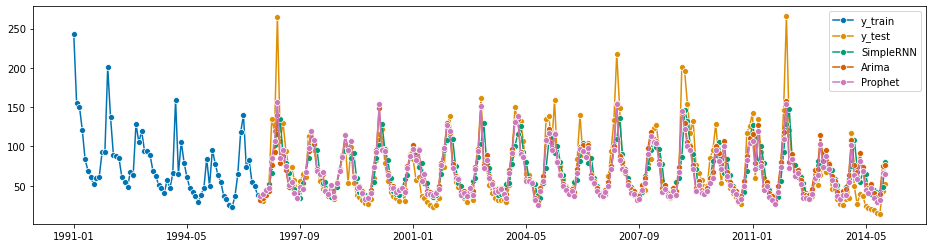

In [98]:
plot_series(y_train_menor_inv,y_test_inv,y_pred_SimpleRNN_inv,
            y_pred_arima_exo_inv,y_pred_prophet_inv,
             labels=["y_train", "y_test", 
                    "SimpleRNN","Arima",
                    "Prophet"])

In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_autoarima,y_pred_autoarima_exo,
            y_pred_arima_1,y_pred_arima_2,y_pred_arima_3,
            y_pred_arima_1_exo,y_pred_arima_2_exo,y_pred_arima_3_exo,
            labels=["y_train", "y_test", 
                    "autoARIMA","autoARIMA exo",
                    "ARIMA 1","ARIMA 2","ARIMA 3",
                    "ARIMA 1 exo","ARIMA 2 exo","ARIMA 3 exo"])

In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_prophet,
            y_pred_dense,
            y_pred_LSTM,
            y_pred_GRU,
            labels=["y_train", "y_test", 
                    "TBATS","TBATS exo",
                    'Prophet',
                    'Dense',
                    'LSTM',
                    'GRU'])

In [ ]:
plot_series(y_train_menor, y_test,
            y_pred_dense,
            y_pred_LSTM,
            y_pred_GRU,
            labels=["y_train", "y_test", 
                    'Dense',
                    'LSTM',
                    'GRU'])

In [ ]:
plot_series(y_train_menor_inv, y_test_inv,
            y_pred_dense_inv,
            y_pred_LSTM_inv,
            y_pred_GRU_inv,
            labels=["y_train", "y_test", 
                    'Dense',
                    'LSTM',
                    'GRU'])